In [1]:
%load_ext autoreload
%autoreload 2

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from incendio.layers import mish
from incendio.utils import get_einops_image, plot_img_batch

In [131]:
cd_root()

Current directory: /Users/hmamin/incendio


In [132]:
bs = 2
n_seq = 4
n_emb = 8

In [133]:
x = torch.randn(bs, n_seq, n_emb)
x.shape

torch.Size([2, 4, 8])

In [16]:
lin = nn.Linear(n_emb, n_emb*3)
qkv = lin(x)
qkv.shape

torch.Size([2, 4, 24])

In [17]:
q, k, v = qkv.chunk(3, dim=-1)

In [20]:
smap(q, k, v)

[torch.Size([2, 4, 8]), torch.Size([2, 4, 8]), torch.Size([2, 4, 8])]

In [21]:
qk = q @ k.transpose(-2, -1)
qk.shape

torch.Size([2, 4, 4])

In [22]:
w = F.softmax(qk/np.sqrt(k.shape[-1]), dim=-1)
w.shape

torch.Size([2, 4, 4])

In [23]:
w.shape, v.shape

(torch.Size([2, 4, 4]), torch.Size([2, 4, 8]))

In [24]:
w

tensor([[[0.3194, 0.2145, 0.2537, 0.2123],
         [0.1481, 0.3938, 0.1637, 0.2944],
         [0.3235, 0.2150, 0.2943, 0.1672],
         [0.2114, 0.3958, 0.1450, 0.2478]],

        [[0.1403, 0.1413, 0.4371, 0.2814],
         [0.1405, 0.1811, 0.4477, 0.2307],
         [0.2538, 0.2546, 0.2017, 0.2899],
         [0.1906, 0.2334, 0.2060, 0.3700]]], grad_fn=<SoftmaxBackward>)

In [25]:
w.sum(-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)

In [26]:
v

tensor([[[-0.9252, -0.7189,  0.5745, -0.0615, -0.8207, -0.2445,  0.1443,
           0.2584],
         [-0.1945,  0.0850,  0.6434,  0.5749,  0.2454, -0.1575, -0.2515,
           0.9941],
         [-0.3747, -0.3643,  0.0776,  0.1407, -0.7063, -0.2824,  0.0551,
           0.2374],
         [-0.4754,  0.6410,  0.0406, -0.0262,  0.4806, -1.2904, -0.1688,
           0.8364]],

        [[-0.8540,  0.4700,  0.0350,  0.1249,  0.2180, -0.8239,  0.5342,
           0.9115],
         [-0.6555, -0.1389,  0.0239, -0.5375, -0.3968, -1.3929, -0.4080,
           0.5622],
         [-0.0428, -0.5596,  0.8501,  0.3117, -0.2734,  0.3237,  0.3952,
           0.7681],
         [-0.4201,  0.8392,  0.4082,  0.9275,  0.6644,  0.3775,  0.9765,
           1.1330]]], grad_fn=<SplitBackward>)

In [27]:
res = w @ v
res.shape

torch.Size([2, 4, 8])

In [235]:
class Projector(nn.Module):
    
    def __init__(self, n_in, n_out_single, spaces=3):
        super().__init__()
        self.spaces = spaces
        self.n_out_single = n_out_single
        self.fc = nn.Linear(n_in, n_out_single*spaces)
        
    def forward(self, x):
        return self.fc(x).chunk(self.spaces, dim=-1)

## TODO: detour testing fc projector vs conv projector

NOTE: nn.Linear only acts on last dimension so if we pass in input of shape (bs, seq_len, emb_dim), we're not really using the seq dimension here. Maybe refresh memory of 1d conv to see if that would take both into account in the way I want. Otherwise we could do some reshaping before feeding to linear layer.

In [136]:
img = get_einops_image()
img_bw = get_einops_image(color=False)
img.shape, img_bw.shape

Writing data to /Users/hmamin/.incendio/einops.zip.
Object loaded from /Users/hmamin/.incendio/einops.zip.
Object loaded from /Users/hmamin/.incendio/einops.zip.


(torch.Size([6, 3, 96, 96]), torch.Size([6, 96, 96]))

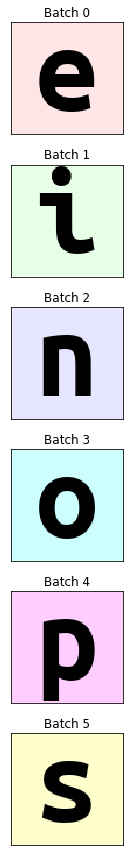

In [137]:
plot_img_batch(img)

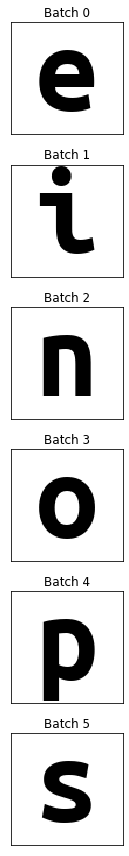

In [138]:
plot_img_batch(img_bw)

In [32]:
conv = nn.Conv1d(n_emb, n_emb*3, kernel_size=3, padding=1)
conv(x.permute(0, 2, 1)).shape

torch.Size([2, 24, 4])

In [421]:
class DotProductAttention(nn.Module):
    
    def __init__(self, n_in, n_f_single, n_out, n_heads, scale=True, 
                 drop_p1=0.1, drop_p2=0.1, return_attn=False):
        super().__init__()
        assert n_f_single % n_heads == 0, \
            'n_f_single must be divisible by n_heads'
        self.proj_in = Projector(n_in, n_f_single, spaces=3)
        self.drop_in = nn.Dropout(drop_p1)
        self.proj_out = nn.Linear(n_f_single, n_out)
        self.drop_out = nn.Dropout(drop_p2)
        
        # Non-layer attributes.
        self.n_heads = n_heads
        self.scale = scale
        self.drop_p1 = drop_p1
        self.drop_p2 = drop_p2
        self.return_attn = return_attn
        
    def forward(self, x):
        q, k, v = map(self.split_heads, self.proj_in(x))
        scores = q @ k.transpose(-2, -1)
        if self.scale: scores /= np.sqrt(scores.shape[-1])
        weights = F.softmax(scores, dim=-1)
        # Note: Huggingface returns weights post dropout which seems a little
        # odd. Maybe For now I'm just experimenting so I'm skipping that part.
        x = self.drop_in(weights) @ v
        x = self.merge_heads(x)
        x = self.drop_out(self.proj_out(x))
        return (x, weights) if self.return_attn else x
    
    def split_heads(self, inp):
        # Reshape input so hidden_dim is split equally between n heads.
        bs, seq, hid = inp.shape
        return inp.reshape(bs, self.n_heads, seq, hid // self.n_heads)
    
    def merge_heads(self, inp):
        bs, heads, seq, hid = inp.shape
        return inp.permute(0, 2, 1, 3).reshape(bs, seq, -1)
    
# class MultiHeadAttention(DotProductAttention):
    
#     def __init__(self, n_in, n_f_single, n_heads, scale=True, drop_p=0.1,
#                  return_attn=False):
#         super().__init__(n_in, n_f_single, scale, drop_p, return_attn)
#         self.n_heads = n_heads
        
#     def forward(self, x):
#             q, k, v = map(self.split_heads, x)
#             return super().forward((q, k, v))

In [417]:
proj = Projector(n_emb, n_emb)
qkv = proj(x)
attrmap('shape', *qkv)

[torch.Size([2, 4, 6]), torch.Size([2, 4, 6]), torch.Size([2, 4, 6])]

In [418]:
print(x.shape)
attn = DotProductAttention(n_emb, n_emb, n_emb*2, 1)
res = attn(x)
print(res.shape)
res

torch.Size([2, 4, 6])
torch.Size([2, 4, 12])


tensor([[[-0.0219,  0.1480, -0.0779, -0.3398,  0.2438,  0.0000,  0.3983,
          -0.3061,  0.0000,  0.0000,  0.2716, -0.2372],
         [-0.0094,  0.1142,  0.0164, -0.3359, -0.0000,  0.1062,  0.4832,
          -0.4665,  0.7347,  0.0000,  0.0475,  0.0112],
         [ 0.0257,  0.0845, -0.0568, -0.3908,  0.2509,  0.1602,  0.3955,
          -0.0000,  0.5900,  0.0692,  0.3223, -0.2070],
         [-0.0941,  0.1840, -0.0285, -0.3601, -0.0759,  0.0678,  0.4196,
          -0.4413,  0.0000,  0.0787, -0.0043,  0.0018]],

        [[ 0.0991, -0.1446,  0.0258, -0.5993,  0.0666,  0.2172,  0.3595,
          -0.4314,  1.0157,  0.1354,  0.3244,  0.0982],
         [ 0.0345, -0.0287,  0.0219, -0.0000, -0.0130,  0.1340,  0.3629,
          -0.4824,  0.9026,  0.1333,  0.2206,  0.0440],
         [ 0.1349, -0.1238, -0.0000, -0.4414,  0.2259,  0.3804,  0.5059,
          -0.1504,  0.8223,  0.1075,  0.0000,  0.0233],
         [ 0.0000, -0.0000, -0.0891, -0.4575,  0.2274,  0.3732,  0.4891,
          -0.0000,  0.

In [419]:
attn = DotProductAttention(n_emb, n_emb*2, n_emb, n_heads=3)
res = attn(x)
res.shape

torch.Size([2, 4, 6])

In [145]:
class FanForward(nn.Module):
    """Fan out and back in. Not really sure why though since we end up with 
    the same shape."""
    
    def __init__(self, n_in, hidden_scalar, drop_p=0.1, act=mish):
        super().__init__()
        n_hid = n_in * hidden_scalar
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_in)
        self.act = act
        self.drop = nn.Dropout(drop_p)
        
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.drop(self.act(self.fc2(x)))

In [423]:
class TransformerDecoder(nn.Module):
    
    def __init__(self):
        super().__init__()
#         DotProductAttention()
#         FanForward()
        
    def forward(self, x):
        return x

In [84]:
FanForward(5, 6)

FanForward(
  (fc1): Linear(in_features=5, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
)

In [81]:
ff = FanForward(n_emb, 4)
ff(x).shape

torch.Size([2, 4, 12])


torch.Size([2, 4, 3])

In [156]:
from transformers.modeling_gpt2 import Attention

In [166]:
config = Args(n_head=1, attn_pdrop=.1, resid_pdrop=.1, n_ctx=n_emb*2, 
              n_layer=1, n_embd=n_emb, layer_norm_epsilon=1e-3,
              output_attentions=False)
attn_gpt = Attention(n_emb, n_emb*2, config)
res_gpt = attn_gpt(x)
len(res_gpt)

2

In [169]:
res_gpt[-2].shape

torch.Size([2, 4, 3])

In [171]:
attn_gpt.c_attn(x).shape

torch.Size([2, 4, 9])

In [61]:
# FROM BLOG POST
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x
    
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.act(self.c_fc(x))
        print(x.shape)
        return self.dropout(self.c_proj(x))

In [62]:
FeedForward(0, n_emb, n_emb*4)(x).shape

torch.Size([2, 4, 12])


torch.Size([2, 4, 3])

In [54]:
w.shape, v.shape

(torch.Size([2, 4, 4]), torch.Size([2, 4, 3]))

In [27]:
z = torch.randn(bs, n_seq, n_emb, n_emb)
z.shape

torch.Size([2, 4, 3, 3])

In [30]:
lin2 = nn.Linear(3, 5)
lin2(z).shape

torch.Size([2, 4, 3, 5])

In [33]:
lin2.weight

Parameter containing:
tensor([[-0.5565, -0.2874, -0.5044],
        [ 0.3084,  0.2368, -0.2929],
        [-0.1206,  0.0814, -0.2280],
        [ 0.1191,  0.0834, -0.2181],
        [-0.0737,  0.3648,  0.3930]], requires_grad=True)

In [34]:
z.dim()

4